In [1]:
[x, sr] = audioread('data/whale_singing_excerpt.wav');

In [2]:
q = 1;
tdeci = 300;
over = 2;
noct = 100;
minf = 0.02;
maxf = 0.06;

In [3]:
lint = 0.5;         % do not follow if reassignment takes you far
MAXL = 2^27;        % maximum length of vector to avoid paging 

N = length(x);

xf = fft(x);       % this is an "inverted" spectrogram, calculated from frequencies

HT = ceil(N/tdeci);                     % number of final time bins (assuming 'tdeci' is the time window size)
HF = ceil( -noct*log2(minf/maxf)+1);    % number of final freq bins, i.e. number of octaves * divisions between fmin and fmax. +1 so that maxf is indexed over in log2f0, below
histo = spalloc(HT,HF,N);
histc = spalloc(HT,HF,N); 

% prepare the masks

f=(0.0:N-1)/N;

allt = [];
allf = [];
alle = [];
allc = [];

for log2f0=0:( (HF*over) -1) % indices of oversampled (sub-subdivided) subdivided octaves
    f0 = minf*2^(log2f0/over/noct); % frequencies (Hz) corresponding to octave subdivision indices
    sigma = f0/(2*pi*q); % changed to 1/2pi % Gaussian parameter: increases with center frequency (f0), decreases with q (set bigger for more freq resolution)
    gau = exp( -(f-f0).^2 / (2*sigma^2)); % Gaussian window over entire frequency axis (centered at f0)
    gde = -1/sigma^1 * (f-f0) .* gau; % "eta" window over entire frequency axis (centered at f0)
    
    % compute reassignment operator
    xi = ifft( gau' .* xf); % calculate ifft of Gaussian-windowed snippet 
    eta= ifft( gde' .* xf); % calculate ifft of eta-windowed snippet
    mp = ( eta ./ xi );
    ener = abs(xi).^2; % calculate ifft energy
    
    
    % compute instantaneous time and frequency
    tins = (1:N)' + imag(mp)/(2*pi*sigma);
    fins =     f0 - real(mp)*sigma;
    % mask the results to the histogram domain
    mask = (abs(mp)<lint) & (fins < maxf) & (fins>minf) & (tins>=1) & (tins<N); % note that f0 > maxf possible
    tins = tins( mask );
    fins = fins( mask );
    ener = ener( mask );
    % histogram!
    itins = gather( round(tins/tdeci+0.5)); % bin times... +0.5 ensures bin indices > 0
    ifins = gather( round( - noct*log2(fins/maxf)+1) ); % bin freqs... +1 ensures bin indices > 0

    allt = [ allt; itins ];
    allf = [ allf; ifins ];
    alle = [ alle; gather( ener ) ];
    allc = [ allc; (0*itins+1) ];

    if(length(allt)>MAXL)
        histo=histo+sparse(allt,allf,alle,HT,HF);
        histc=histc+sparse(allt,allf,allc,HT,HF);
        allt = [];
        allf = [];
        alle = [];
        allc = []; 
    end


end

histo=histo+sparse(allt,allf,alle,HT,HF);
histc=histc+sparse(allt,allf,allc,HT,HF);

mm = max(max(histc)); 
histo(histc<sqrt(mm)) = 0;
histocomp=spalloc(HT,HF,sum(sum(histo>0))); 
histocomp(histo>0)=histo(histo>0); 

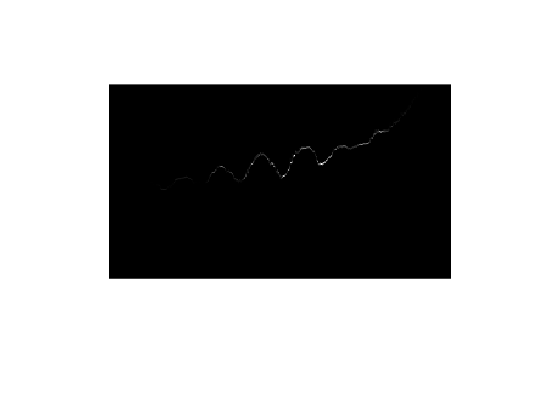

In [4]:
imshow(full(histocomp).', [0, max(full(histocomp), [], 'all')])

In [5]:
save('data/variable_vals_inside_linear_reassignment.mat')